python==3.8 
pip3 install jupyter notebook 
pip3 install ipykernel
pip3 install librosa --user
pip3 install python_speech_features

In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
# Dataset path and view possible targets
dataset_path = "D:/vsc_ws_voice_learning/tflite-speech-recognition/speech_commands_dataset"
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

backward
bed
bird
cat
dog
down
eight
five
follow
forward
four
go
happy
house
learn
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
up
visual
wow
yes
zero
_background_noise_


In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', '_background_noise_']


In [4]:
# Leave off background noise set
all_targets.remove('_background_noise_')
print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [5]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

1664
2014
2064
2031
2128
3917
3787
4052
1579
1557
3728
3880
2054
2113
1575
3801
2100
3934
3941
3745
3845
3890
3778
3998
2022
3860
3872
3727
1759
3880
3723
1592
2123
4044
4052
Total samples: 105829


In [6]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [7]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\backward
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\bed
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\bird
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\cat
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\dog
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\down
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\eight
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\five
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\follow
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\forward
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\four
D:\vsc_ws_voice_learning\tflite-speech-recognition\speech_commands_dataset\go
D:\vsc_ws_voice_learning\tflite-spe

In [8]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.]), array([3., 3., 3., ..., 3., 3., 3.]), array([4., 4., 4., ..., 4., 4., 4.]), array([5., 5., 5., ..., 5., 5., 5.]), array([6., 6., 6., ..., 6., 6., 6.]), array([7., 7., 7., ..., 7., 7., 7.]), array([8., 8., 8., ..., 8., 8., 8.]), array([9., 9., 9., ..., 9., 9., 9.]), array([10., 10., 10., ..., 10., 10., 10.]), array([11., 11., 11., ..., 11., 11., 11.]), array([12., 12., 12., ..., 12., 12., 12.]), array([13., 13., 13., ..., 13., 13., 13.]), array([14., 14., 14., ..., 14., 14., 14.]), array([15., 15., 15., ..., 15., 15., 15.]), array([16., 16., 16., ..., 16., 16., 16.]), array([17., 17., 17., ..., 17., 17., 17.]), array([18., 18., 18., ..., 18., 18., 18.]), array([19., 19., 19., ..., 19., 19., 19.]), array([20., 20., 20., ..., 20., 20., 20.]), array([21., 21., 21., ..., 21., 21., 21.]), array([22., 22., 22., ..., 22., 22., 22.]), array([23., 23., 23., ..., 23., 23., 23.]), arr

In [9]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [10]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [11]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

105829
105829


In [12]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [13]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [14]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [15]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [16]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

Dropped: 11 (16, 13)
Dropped: 13 (16, 10)
Dropped: 17 (16, 12)
Dropped: 22 (16, 9)
Dropped: 23 (16, 12)
Dropped: 31 (16, 14)
Dropped: 58 (16, 11)
Dropped: 60 (16, 11)
Dropped: 63 (16, 6)
Dropped: 77 (16, 12)
Dropped: 83 (16, 11)
Dropped: 89 (16, 11)
Dropped: 98 (16, 13)
Dropped: 112 (16, 13)
Dropped: 115 (16, 14)
Dropped: 126 (16, 6)
Dropped: 138 (16, 12)
Dropped: 182 (16, 15)
Dropped: 188 (16, 13)
Dropped: 192 (16, 15)
Dropped: 195 (16, 11)
Dropped: 206 (16, 9)
Dropped: 208 (16, 13)
Dropped: 225 (16, 14)
Dropped: 240 (16, 15)
Dropped: 246 (16, 12)
Dropped: 252 (16, 15)
Dropped: 262 (16, 15)
Dropped: 272 (16, 9)
Dropped: 291 (16, 11)
Dropped: 303 (16, 2)
Dropped: 345 (16, 14)
Dropped: 349 (16, 14)
Dropped: 353 (16, 13)
Dropped: 354 (16, 9)
Dropped: 359 (16, 14)
Dropped: 370 (16, 13)
Dropped: 380 (16, 11)
Dropped: 381 (16, 10)
Dropped: 388 (16, 15)
Dropped: 401 (16, 14)
Dropped: 407 (16, 8)
Dropped: 411 (16, 12)
Dropped: 417 (16, 11)
Dropped: 423 (16, 11)
Dropped: 424 (16, 13)
Dropped: 

In [17]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.1


pip3 install playsound==1.2.2

MFCCs: [[-3.76909556e+01 -3.89135834e+01 -3.66833367e+01 -2.67393700e+01
  -1.98677894e+01 -1.74503649e+01 -1.82429902e+01 -1.95752979e+01
  -2.00691882e+01 -2.32410115e+01]
 [ 1.35473446e+01  1.52244050e+01  1.31636883e+01  9.50291896e+00
   8.49843492e+00  8.14557373e+00  8.37628603e+00  8.92894343e+00
   8.61135774e+00  9.18871615e+00]
 [ 3.61022869e+00  2.88258502e+00  3.57851882e+00  8.35915090e-01
  -2.42498429e+00 -3.37428687e+00 -2.38193848e+00 -1.51220639e+00
  -1.55221684e+00 -8.63722098e-01]
 [ 7.92119677e-01  9.10646845e-01  1.13055016e+00  7.33050239e-01
  -1.28386936e+00 -2.76184335e+00 -4.42947042e+00 -5.06861719e+00
  -3.93937067e+00 -2.24681073e+00]
 [ 6.31157575e-01  5.34633058e-01  5.03621589e-01 -7.97629205e-02
  -7.96378553e-01 -9.14724243e-01 -7.87140001e-01 -5.04508372e-01
  -9.29592576e-02  4.23527521e-01]
 [ 1.39648711e+00  1.55410942e+00  1.37384912e+00 -3.38248547e-01
   1.05174609e+00  2.93400286e+00  4.58608527e+00  5.05524921e+00
   4.19631195e+00  2.70661

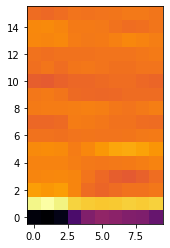

In [18]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [19]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [20]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 11 (16, 13)
Dropped: 13 (16, 10)
Dropped: 17 (16, 12)
Dropped: 22 (16, 9)
Dropped: 23 (16, 12)
Dropped: 31 (16, 14)
Dropped: 58 (16, 11)
Dropped: 60 (16, 11)
Dropped: 63 (16, 6)
Dropped: 77 (16, 12)
Dropped: 83 (16, 11)
Dropped: 89 (16, 11)
Dropped: 98 (16, 13)
Dropped: 112 (16, 13)
Dropped: 115 (16, 14)
Dropped: 126 (16, 6)
Dropped: 138 (16, 12)
Dropped: 182 (16, 15)
Dropped: 188 (16, 13)
Dropped: 192 (16, 15)
Dropped: 195 (16, 11)
Dropped: 206 (16, 9)
Dropped: 208 (16, 13)
Dropped: 225 (16, 14)
Dropped: 240 (16, 15)
Dropped: 246 (16, 12)
Dropped: 252 (16, 15)
Dropped: 262 (16, 15)
Dropped: 272 (16, 9)
Dropped: 291 (16, 11)
Dropped: 303 (16, 2)
Dropped: 345 (16, 14)
Dropped: 349 (16, 14)
Dropped: 353 (16, 13)
Dropped: 354 (16, 9)
Dropped: 359 (16, 14)
Dropped: 370 (16, 13)
Dropped: 380 (16, 11)
Dropped: 381 (16, 10)
Dropped: 388 (16, 15)
Dropped: 401 (16, 14)
Dropped: 407 (16, 8)
Dropped: 411 (16, 12)
Dropped: 417 (16, 11)
Dropped: 423 (16, 11)
Dropped: 424 (16, 13)
Dropped: 

In [21]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [22]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [23]:
len(feature_sets['x_train'])

77488

In [24]:
print(feature_sets['y_val'])

[10. 27. 11. ...  3. 23. 33.]
